# Code for minimizing the energy functional for a set of step heights and burgers vectors

In [367]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt


def read_data(path_r):
    # Read data from ref config
    i = 0
    q = -1
    j = q
    data = []
    k=0
    with open(path_r,'r') as file:
        flag = 0
        
        for line in file:
            fields = line.split(' ')
            i = i+1
            if(len(fields)==3 and fields[0] == "Sigma"):
                j=-1
                flag = 1
                row = []
                sig = (float(fields[2]))

            if(fields[0] == "Misorientation="):
                n = len(fields)
                mis = (float(fields[n-1]))
                
            if (len(fields)>15): 
                nrow =[]
                if fields[2] != "Inclination" and fields[1] != "-------------":
                    flag = 2
                    for t in range(len(fields)):
                        if fields[t]!="":
                            j = j+1
                            nrow.append(fields[t])
                            '''
                            #print(fileds)
                            pos1[j,0] = float(fields[0]) # inclination
                            pos1[j,1] = float(fields[7]) # period
                            pos1[j,2] = float(fields[8]) # b
                            pos1[j,3] = float(fields[14]) # h
                            pos1[j,4] = float(fields[15]) # H           
                            pos1[j,5] = float(fields[6]) # F11
                            pos1[j,6] = float(fields[7]) # F21
                            pos1[j,7] = float(fields[8]) # F12
                            pos1[j,8] = float(fields[9]) # F22
                            '''
                    #row format = {sigma,mis,inc,period,bx,bz,h,H}
            if flag == 2:        
                row = [sig,mis,float(nrow[0]),float(nrow[7]),float(nrow[8]),float(nrow[10]),float(nrow[14]),float(nrow[15]),float(nrow[1]),float(nrow[2]),float(nrow[3])]
                #print(nrow)
                data.append(row)
    return data
   
def find_dis_pairs(data,num):#(sig,mis,inc,period,b1,b3,h,H,n_b,n_h):
    pairs = []
    sig = data[0]
    mis = data[1]
    inc = data[2]
    period = data[3]
    b1 = data[4]
    b3 = data[5]
    h = data[6]
    H = data[7]
    n_b = num[0]
    n_h = num [1]
    print(sig,mis,b1,b3)
    for i in range(-n_b,n_b+1):
        if i==0:
            continue
        burgers_vec = i*(b1**2+b3**2)**(1/2)
        step_height_1 = (i*h)%period
        step_height_2 = -period+step_height_1 
        for j in range(n_h+1):
            row1 = [mis, inc, burgers_vec,(step_height_1+period*j)]
            row2 = [mis, inc, burgers_vec,(step_height_2-period*j)]
            pairs.append(row1)
            pairs.append(row2)
    return pairs
    
    
def read_GBindex_energy(path_in,path_en):
    en_data = []
    flag = 0
    with open(path_en,'r') as file:
        for line in file:
            fields = line.split("\t")
            if len(fields)>2:
                flag = 1
                nrow =[]
                for t in range(len(fields)):
                    if fields[t]!="":
                        nrow.append(float(fields[t]))
            else: flag =0
            if flag == 1:
                en_data.append(nrow)
    energy = np.asarray(en_data)
    j = -1
    data = []
    k=0
    with open(path_in,'r') as file:
        flag = 0
        for line in file:
            fields = line.split(' ')
            if len(fields)==4:
                index = int(fields[3])
            if (len(fields)>15): 
                nrow =[]
                for t in range(len(fields)):
                    if fields[t]!="":
                        j = j+1
                        nrow.append(fields[t])
                if (nrow[0] == "1" and nrow[1] == "0" and nrow[2] == "0" and nrow[11]=="tilt"):
                    row = [index,float(nrow[4]),[float(nrow[5]),float(nrow[6]),float(nrow[7])],[float(nrow[8]),float(nrow[9]),float(nrow[10])],energy[index-1,1],energy[index-1,2]]
                    data.append(row)
    return data



# Find all sets of possible step heights and burgers vectors
def find_min_energy(e,data,num):
    r,c = e.shape
    r1,c1 = data.shape
    disconnection = np.zeros((1,2))
    beta = 0
    min_e = []
    tot_e = []
    for i in range(r):
        flag = 0
        mis = e[i,0]
        g = e[i,1]
        for j in range(r1):
            if abs(data[j,1]-mis)<0.1 and data[j,2] == 0.0:
                data_mis = data[j,:]
                flag = 1
        if flag == 1:
            pairs = np.asarray(find_dis_pairs(data_mis,num))
            E_min = 100
            tau = 1     #applied shear
            mu =  44*1e9    # shear modulus
            nu = 0.3  # poisson's ratio
            kappa = mu/(4*np.pi*(1-nu))
            alpha = 0.3
            theta = 90*np.pi/180
            gs = g # interfacial energy that constitutes the step
            gamma_S = gs-g*np.cos(theta)/np.sin(theta)
            for k in range(len(pairs)):
                t_e = []
                b_temp = pairs[k,2]*1e-10
                h_temp = pairs[k,3]*1e-10
                delta_0 = b_temp/alpha
                E = 2*gamma_S*abs(h_temp)+2*kappa*(b_temp**2)*np.log(2*kappa*b_temp/(tau*delta_0)) 
                print(2*gamma_S*abs(h_temp),np.log(2*kappa*b_temp/(tau*delta_0)) )
                nrow = [mis,g,E,b_temp/h_temp]
                tot_e.append(nrow)
                if (E<E_min):
                    E_min = E
                    disconnection[0,0] = b_temp
                    disconnection[0,1] = h_temp
                    beta = b_temp/h_temp
            row = [mis,g,disconnection[0,0],disconnection[0,1],beta]
            min_e.append(row)
            

    return min_e,tot_e
'''
def findin_energy(shift,height,csl,n_disconnections):
    h_list = []
    b_list = []
    disconnection = np.zeros((1,2))
    E_min = 100
    tau = 1
    mu =  44    # shear modulus
    nu = 0.3  # poisson's ratio
    kappa = mu/(4*np.pi*(1-nu))
    alpha = 3
    g = 0 # interfacial energy of the refernce boundary
    gs = 0 # interfacial energy that constitutes the step
    theta = 0 # inclination between step plane and gb
    gamma_S = gs-g*np.cos(theta)/np.sin(theta)
    for i in range(-n_disconnections,n_disconnections+1):
        b_temp = i*shift
        h_temp = (i*height)%csl
        delta_0 = b_temp/alpha
        E = 2*gamma_s*abs(h_temp)+2*kappa*(b_temp**2)*np.log(2*kappa*b_temp/(e*tau*delta_0)) 
        if (E<E_min):
            E_min = E
            disconnection[0,0] = b_temp
            disconnection[0,1] = h_temp
        h_list.append(h_temp)
        b_list.append(b_temp)
'''

"\ndef findin_energy(shift,height,csl,n_disconnections):\n    h_list = []\n    b_list = []\n    disconnection = np.zeros((1,2))\n    E_min = 100\n    tau = 1\n    mu =  44    # shear modulus\n    nu = 0.3  # poisson's ratio\n    kappa = mu/(4*np.pi*(1-nu))\n    alpha = 3\n    g = 0 # interfacial energy of the refernce boundary\n    gs = 0 # interfacial energy that constitutes the step\n    theta = 0 # inclination between step plane and gb\n    gamma_S = gs-g*np.cos(theta)/np.sin(theta)\n    for i in range(-n_disconnections,n_disconnections+1):\n        b_temp = i*shift\n        h_temp = (i*height)%csl\n        delta_0 = b_temp/alpha\n        E = 2*gamma_s*abs(h_temp)+2*kappa*(b_temp**2)*np.log(2*kappa*b_temp/(e*tau*delta_0)) \n        if (E<E_min):\n            E_min = E\n            disconnection[0,0] = b_temp\n            disconnection[0,1] = h_temp\n        h_list.append(h_temp)\n        b_list.append(b_temp)\n"

In [368]:

# Read the file
path_r = '/home/himanshu/Desktop/ResearchResults/fcc0-10.txt'
path_in = '/home/himanshu/Desktop/ResearchResults/GBIndex.txt'
path_en = '/home/himanshu/Desktop/ResearchResults/Energy.txt'
# data format [sigma, mis, inc,period,b1,b3,h,H]
data = np.asarray(read_data(path_r))
gbin = read_GBindex_energy(path_in,path_en) # From Olmstead
energy_array = np.array([[11.42,0.684],
                         [16.26,0.796],
                         [18.92,0.837],
                         [22.62,0.878],
                         [28.07,0.914],
                         [31.89,0.939], 
                         [36.87,0.905],
                         [53.13,0.952],
                         [61.93,0.856],
                         [67.38,0.790],
                         [71.08,0.732],
                         [73.74,0.677],
                         [77.32,0.595],
                         [79.61,0.533]])

In [369]:
num_disconnection = np.asarray([1,2])
a,b=find_min_energy(energy_array,data,num_disconnection)

101.0 11.42119 0.0995 0.0
1.3067628480000001e-09 21.822280544068125
6.806073599999997e-11 21.822280544068125
2.6815864320000004e-09 21.822280544068125
1.44288432e-09 21.822280544068125
4.056410016000001e-09 21.822280544068125
2.8177079039999997e-09 21.822280544068125
6.806073600000001e-11 21.822280544068125
1.3067628480000001e-09 21.822280544068125
1.44288432e-09 21.822280544068125
2.6815864320000004e-09 21.822280544068125
2.817707904e-09 21.822280544068125
4.056410016000001e-09 21.822280544068125
25.0 16.2602 0.14142 0.0
2.0262816800000003e-10 21.822280544068125
3.60228208e-10 21.822280544068125
7.654845440000001e-10 21.822280544068125
9.230845840000001e-10 21.822280544068125
1.3283409200000002e-09 21.822280544068125
1.4859409600000003e-09 21.822280544068125
3.60228208e-10 21.822280544068125
2.0262816800000003e-10 21.822280544068125
9.230845840000001e-10 21.822280544068125
7.654845440000001e-10 21.822280544068125
1.4859409600000003e-09 21.822280544068125
1.3283409200000002e-09 21.8222

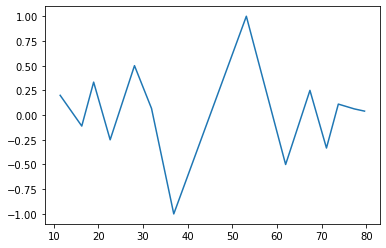

In [370]:
aa = np.asarray(a)
plt.plot(aa[:,0],aa[:,4])

In [371]:
aa

array([[ 1.14200000e+01,  6.84000000e-01, -9.95000000e-12,
        -4.97520000e-11,  1.99991960e-01],
       [ 1.62600000e+01,  7.96000000e-01, -1.41420000e-11,
         1.27279000e-10, -1.11110238e-01],
       [ 1.89200000e+01,  8.37000000e-01, -1.64400000e-11,
        -4.93200000e-11,  3.33333333e-01],
       [ 2.26200000e+01,  8.78000000e-01, -1.96120000e-11,
         7.84460000e-11, -2.50006374e-01],
       [ 2.80700000e+01,  9.14000000e-01, -2.42540000e-11,
        -4.85070000e-11,  5.00010308e-01],
       [ 3.18900000e+01,  9.39000000e-01, -1.37360000e-11,
        -2.06041000e-10,  6.66663431e-02],
       [ 3.68700000e+01,  9.05000000e-01, -3.16230000e-11,
         3.16230000e-11, -1.00000000e+00],
       [ 5.31300000e+01,  9.52000000e-01, -4.47210000e-11,
        -4.47210000e-11,  1.00000000e+00],
       [ 6.19300000e+01,  8.56000000e-01, -1.71500000e-11,
         3.43000000e-11, -5.00000000e-01],
       [ 6.73800000e+01,  7.90000000e-01, -2.77350000e-11,
        -1.10940000e-10